In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [38]:
import matplotlib.pyplot as plt
import seaborn as sea_born
sea_born.set()
from PIL import Image
from sklearn.model_selection import train_test_split


In [6]:
root="/kaggle/input/lemon-quality-dataset/lemon_dataset/"

In [11]:
categories=os.listdir(root)
categories.remove('.git')

In [16]:
images = []
labels = []
for category in categories:
    directory = root + category + '/'
    for image_file in os.listdir(directory):
        images.append(directory + image_file)
        labels.append(category)


In [17]:
images = pd.Series(images, name="Image")
labels = pd.Series(labels, name="Quality")


In [28]:
data=pd.concat([images,labels], axis=1)
data.head()

,Image,Quality
0,/kaggle/input/lemon-quality-dataset/lemon_data...,empty_background
1,/kaggle/input/lemon-quality-dataset/lemon_data...,empty_background
2,/kaggle/input/lemon-quality-dataset/lemon_data...,empty_background
3,/kaggle/input/lemon-quality-dataset/lemon_data...,empty_background
4,/kaggle/input/lemon-quality-dataset/lemon_data...,empty_background


In [29]:
data=data.sample(frac=1).reset_index(drop = True)
data.head()

,Image,Quality
0,/kaggle/input/lemon-quality-dataset/lemon_data...,empty_background
1,/kaggle/input/lemon-quality-dataset/lemon_data...,empty_background
2,/kaggle/input/lemon-quality-dataset/lemon_data...,bad_quality
3,/kaggle/input/lemon-quality-dataset/lemon_data...,good_quality
4,/kaggle/input/lemon-quality-dataset/lemon_data...,bad_quality


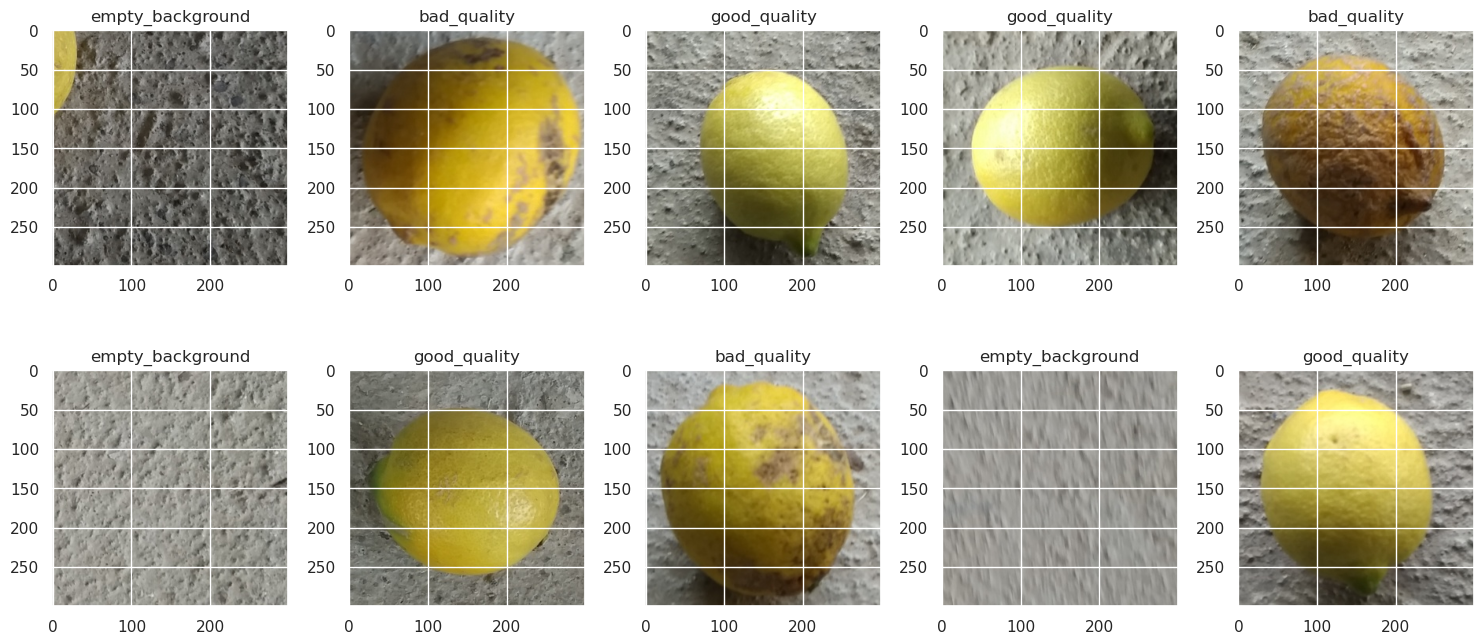

In [31]:
fig, axes = plt.subplots(2, 5, figsize=(15, 7))

for ax in axes.flat:
    i = np.random.randint(0, data.shape[0])
    ax.imshow(Image.open(data.loc[i, "Image"]))
    ax.set_title(data.Quality[i])
    ax.grid(True)  

plt.tight_layout()
plt.show()


In [35]:
dev, held_out =train_test_split(
    data, 
    train_size=0.9, 
    shuffle=True,
    random_state=42)

In [36]:
print(dev.shape)
print(held_out.shape)

(2275, 2)
(253, 2)


In [41]:
import keras
from keras.preprocessing import image

In [43]:
# Rescaling and Data Augmentation
dev_generator = image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    validation_split=0.2
)

# In this case, the generator performs rescaling (normalization) on the image.
# Each pixel value is divided by 255 to obtain values in the range [0, 1].
held_generator = image.ImageDataGenerator(rescale=1./255)


In [48]:
train_images = dev_generator.flow_from_dataframe(
    dataframe=dev,  # Make sure to provide the correct DataFrame
    x_col='Image',  # Update to the correct column name for images
    y_col='Quality',  # Update to the correct column name for labels
    target_size=(150, 150),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)


Found 1820 validated image filenames belonging to 3 classes.


In [49]:
val_images = dev_generator.flow_from_dataframe(
    dataframe=dev,
    x_col='Image',
    y_col='Quality',
    target_size=(150, 150),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

Found 455 validated image filenames belonging to 3 classes.


In [52]:
held_images = held_generator.flow_from_dataframe(
    dataframe=held_out,
    x_col='Image',
    y_col='Quality',
    target_size=(150, 150),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 253 validated image filenames belonging to 3 classes.


In [55]:
labels = train_images.class_indices
labels

{'bad_quality': 0, 'empty_background': 1, 'good_quality': 2}

In [57]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from keras.optimizers import SGD

In [72]:
model = Sequential()

In [73]:
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(150,150,3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

In [74]:
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

In [75]:
model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dense(3, activation='softmax'))

In [77]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_4 (Batc  (None, 74, 74, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_15 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                      

In [83]:
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc', 'mse'])

In [84]:
early_stop = EarlyStopping(monitor='val_loss', patience=8, verbose=1, min_delta=1e-4, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1, min_delta=1e-4)
callbacks_list = [early_stop, reduce_lr]

In [ ]:
history = model.fit(train_images, validation_data=val_images, epochs=15, callbacks=callbacks_list)

Epoch 1/15
57/57 [==============================] - 93s 2s/step - loss: 0.1453 - acc: 0.9467 - mse: 0.0274 - val_loss: 0.2502 - val_acc: 0.8967 - val_mse: 0.0480 - lr: 0.0010
Epoch 2/15
57/57 [==============================] - 90s 2s/step - loss: 0.1153 - acc: 0.9621 - mse: 0.0192 - val_loss: 0.2044 - val_acc: 0.9363 - val_mse: 0.0366 - lr: 0.0010
Epoch 3/15
57/57 [==============================] - 89s 2s/step - loss: 0.1215 - acc: 0.9604 - mse: 0.0203 - val_loss: 0.1830 - val_acc: 0.9407 - val_mse: 0.0311 - lr: 0.0010
Epoch 4/15
57/57 [==============================] - 93s 2s/step - loss: 0.1049 - acc: 0.9687 - mse: 0.0167 - val_loss: 0.5039 - val_acc: 0.8527 - val_mse: 0.0775 - lr: 0.0010
Epoch 5/15
57/57 [==============================] - 89s 2s/step - loss: 0.1502 - acc: 0.9604 - mse: 0.0230 - val_loss: 3.2901 - val_acc: 0.5736 - val_mse: 0.2650 - lr: 0.0010
Epoch 6/15
57/57 [==============================] - 92s 2s/step - loss: 0.0846 - acc: 0.9725 - mse: 0.0151 - val_loss: 0.0556

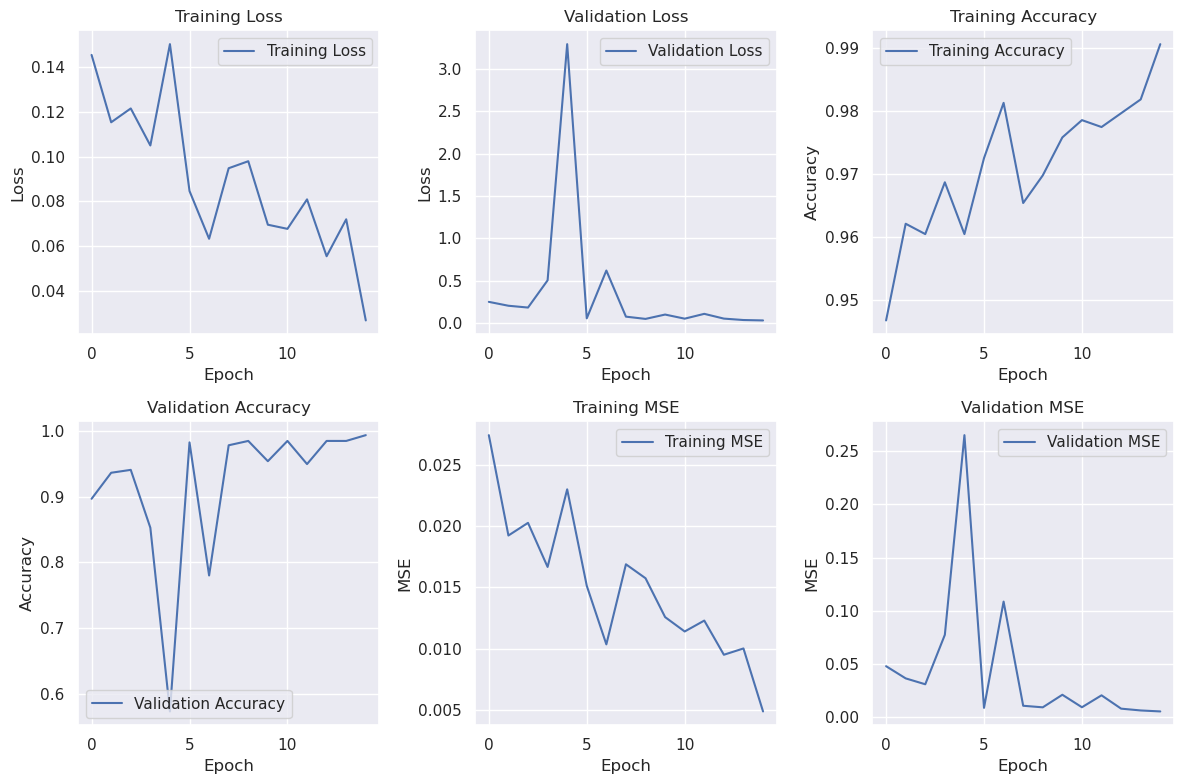

In [90]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Plot training loss
axes[0, 0].plot(history.history['loss'], label='Training Loss')
axes[0, 0].set_title('Training Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Plot validation loss
axes[0, 1].plot(history.history['val_loss'], label='Validation Loss')
axes[0, 1].set_title('Validation Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Plot training accuracy
axes[0, 2].plot(history.history['acc'], label='Training Accuracy')
axes[0, 2].set_title('Training Accuracy')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Accuracy')
axes[0, 2].legend()
axes[0, 2].grid(True)

# Plot validation accuracy
axes[1, 0].plot(history.history['val_acc'], label='Validation Accuracy')
axes[1, 0].set_title('Validation Accuracy')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Plot training MSE
axes[1, 1].plot(history.history['mse'], label='Training MSE')
axes[1, 1].set_title('Training MSE')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('MSE')
axes[1, 1].legend()
axes[1, 1].grid(True)

# Plot validation MSE
axes[1, 2].plot(history.history['val_mse'], label='Validation MSE')
axes[1, 2].set_title('Validation MSE')
axes[1, 2].set_xlabel('Epoch')
axes[1, 2].set_ylabel('MSE')
axes[1, 2].legend()
axes[1, 2].grid(True)

plt.tight_layout()
plt.show()


In [91]:
prediction=model.predict(held_images)

8/8 [==============================] - 3s 318ms/step


In [93]:
prediction=np.argmax(prediction, axis=1)
prediction.shape

(253,)

In [94]:
labels=train_images.class_indices
labels

{'bad_quality': 0, 'empty_background': 1, 'good_quality': 2}

In [150]:
labels = {v: k for k, v in labels.items()}
y_prediction = [labels.get(k) for k in prediction]


In [105]:
y_test=held_out["Quality"].values

In [110]:
from sklearn.metrics import accuracy_score, classification_report



In [112]:
print(classification_report(y_test, y_predictions))

                  precision    recall  f1-score   support

     bad_quality       1.00      0.99      0.99        98
empty_background       1.00      1.00      1.00        49
    good_quality       0.99      1.00      1.00       106

        accuracy                           1.00       253
       macro avg       1.00      1.00      1.00       253
    weighted avg       1.00      1.00      1.00       253



In [114]:
accuracy_score(y_predictions, y_test)

0.9960474308300395

In [115]:
from sklearn.metrics import confusion_matrix

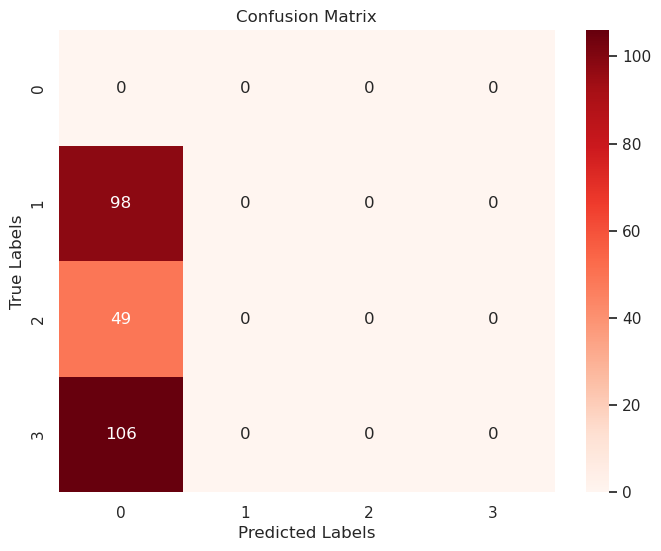

In [122]:
# Create a confusion matrix
cm = confusion_matrix(y_test, y_prediction)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

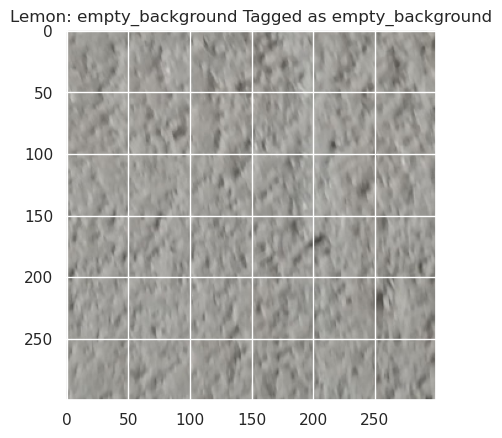

In [169]:
held_out.reset_index(drop=True, inplace=True)
held_out.head()
random_index = np.random.randint(0, held_out.shape[0])
plt.imshow(Image.open(held_out.loc[random_index, "Image"]))
plt.title("Lemon: " + y_test[random_index] + " Tagged as " + y_prediction[random_index])
plt.show()